# Code for Section 6: MLPs More Datasets

This notebook is split into two distinct portions: training and analysis. Training saves all the data required for analysis.
This means that the two parts do not need to be run during the same Jupyter session.

This notebook generates Figure 22 from https://arxiv.org/abs/2301.03962v1

Datasets can be downloaded using the `download_datasets.sh` script in the datasets folder. Be aware that the german credit dataset may need to be unzipped manually on some systems (partucularly on mac).

In [1]:
# PARAMETERS THAT NEED TO BE SET IN BOTH PARTS
N_TRIALS = 100





## Setting up variables

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
from sklearn.neural_network import MLPClassifier
from decompose.data_utils import load_standard_dataset, load_data
from decompose import BVDExperiment
import logging
import time

logger = logging.getLogger()
logger_filename = time.strftime("%y_%m_%d_%H_%M_%S")
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                    filename=f"logs/Section4_MLPs_{logger_filename}.log",
                    datefmt="%Y/%m/%d %H:%M:%S")
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)
logging.getLogger("decomposition.experiments").setLevel(logging.DEBUG)
logging.debug("New Notebook Started")
stream_handler = logging.StreamHandler


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../models/")
from bagging_ensembles import GeometricBaggingClassifier



In [3]:

PARAMETER_VALUES = range(1, 21, 1)
PARAMETER_NAME = "n_estimators"

results_objects = {}

small_network = GeometricBaggingClassifier(
                                      n_estimators=20,
                                      base_estimator=MLPClassifier(solver='sgd',
                                                       learning_rate_init=0.1,
                                                       max_iter=200,
                                                       n_iter_no_change=200,
                                                       hidden_layer_sizes=(20),
                                                       alpha=0,
                                                       nesterovs_momentum=False,
                                                       verbose=False),
                                      warm_start=True,
                                      smoothing_factor=1e-9)

larger_network = GeometricBaggingClassifier(
                                      n_estimators=20,
                                      base_estimator=MLPClassifier(solver='sgd',
                                                       learning_rate_init=0.1,
                                                       max_iter=200,
                                                       n_iter_no_change=200,
                                                       hidden_layer_sizes=(100),
                                                       alpha=0,
                                                       nesterovs_momentum=False,
                                                       verbose=False),
                                      warm_start=True,
                                      smoothing_factor=1e-9)



models = {"Small Network": small_network,
          "Larger Network": larger_network}



# Part A: Training

### Training the Models

In [ ]:
datasets = ["landsat", "phoneme", "spambase", "german_credit"]

for DATASET_NAME in datasets:
    np.random.seed(0)
    train_data, train_labels, test_data, test_labels = load_standard_dataset(DATASET_NAME, 
                                                                             frac_training=0.75, 
                                                                             normalize_data=True)
    for name, model in models.items():
        # Create experiment object and define parameter to vary
        experiment = BVDExperiment(model,
                                   "cross_entropy",
                                   parameter_name=PARAMETER_NAME,
                                   parameter_values=PARAMETER_VALUES,
                                   save_decompositions=True,
                                   decompositions_prefix=f"decomposition_objects/{name}_{DATASET_NAME}_{N_TRIALS}_3")
        # Run experiment on data
        results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=2)
        results_objects[name] = results
        results.save_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_4.pkl")

 25%|██▌       | 5/20 [29:27<1:28:14, 352.98s/it]

# Part B: Analysis

## Set up for Analysis


In [22]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from tqdm import tqdm
from functools import partial
import numpy as np

from decompose.experiments import load_results
from decompose.plotting_utils import plot_bvd

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)


models = ["Small Network", "Larger Network"]
DATASETS = ["phoneme", "spambase", "landsat", "german_credit"]
VAL_IDX = 0
TEST_IDX = 1

decomposition_objects_dict = {}
diversities_dict = {}

for dataset_name in DATASETS:
    # Load results objects from experiment
    results_objects = {}
    for name in models:
        results_objects[name] = load_results(f"data/Fig4_{name}_{dataset_name}_results_{N_TRIALS}_4.pkl")

    PARAMETER_VALUES = range(1, 21, 1)
    
    
    small_results = results_objects["Small Network"]
    large_results = results_objects["Larger Network"]
    diversities_dict[dataset_name] = np.concatenate([small_results.diversity[:, VAL_IDX], large_results.diversity[:, 0]])


    decomposition_objects = [partial(small_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(small_results.parameter_values))]
    decomposition_objects += [partial(large_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(large_results.parameter_values))]
    
    decomposition_objects_dict[dataset_name] = decomposition_objects


    print("objects loaded")

objects loaded
objects loaded
objects loaded
objects loaded


In [23]:


statistics_dict = {}

for dataset_name in decomposition_objects_dict:
    
    stats = {}
    decomposition_objects = decomposition_objects_dict[dataset_name]
    
    # Calculate statistics
    ambiguities_list = []
    ensemble_errors_list = []
    average_individual_errors_list = []

    diversities = np.zeros(len(decomposition_objects))
    central_errors = np.zeros(len(decomposition_objects))
    central_member_errors = np.zeros(len(decomposition_objects))
    all_member_errors = np.zeros(len(decomposition_objects))



    for decomp_idx, decomp in enumerate(tqdm(decomposition_objects)):
        decomp = decomp()
        pred = decomp.pred
        labels = decomp.labels


        predicted_class = np.argmax(decomp.pred, axis=3)

        average_individual_errors = np.zeros((pred.shape[0]))

        for i in range(pred.shape[1]):
            for j in range(pred.shape[0]):
                average_individual_errors[j] += 1 / pred.shape[1] * zero_one_loss(labels, predicted_class[j, i, :])


        # Stuff for ensemble error

        ensemble_errors = np.zeros((pred.shape[0]))
        ensemble_preds = decomp._inverse_generator_gradient(
                                            decomp.etas.mean(axis=1, keepdims=False))

        predicted_class = np.argmax(ensemble_preds, axis=2)
        for j in range(pred.shape[0]):
            ensemble_errors[j] = zero_one_loss(labels, predicted_class[j, :])
        ambiguities = decomp._bregman_expectation(1, (), 1).mean(axis=1)

        ensemble_errors_list.append(ensemble_errors)
        average_individual_errors_list.append(average_individual_errors)

        # Centroids

        diversity =  decomp.diversity.mean()
        diversities[decomp_idx] = diversity

        central_ensemble_pred = decomp._inverse_generator_gradient(
                                            decomp.etas.mean(axis=(0, 1), keepdims=False))

        ensemble_pred_class = np.argmax(central_ensemble_pred, axis=-1)
        
    stats["diversities"] = diversities
    stats["ensemble_errors"] = ensemble_errors_list
    stats["average_individual_errors"] = average_individual_errors_list
    statistics_dict[dataset_name] = stats
        



100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


(40,)
(40,)
dataset: phoneme
Small R^2 0.9772762743828918
Large R^2 0.9910183875903749
(40,)
(40,)
dataset: spambase
Small R^2 0.9608646300979107
Large R^2 0.8717150631422573
(40,)
(40,)
dataset: landsat
Small R^2 0.994477867864221
Large R^2 0.9942382524160085
(40,)
(40,)
dataset: german_credit
Small R^2 0.9154547663266651
Large R^2 0.9740222948841705


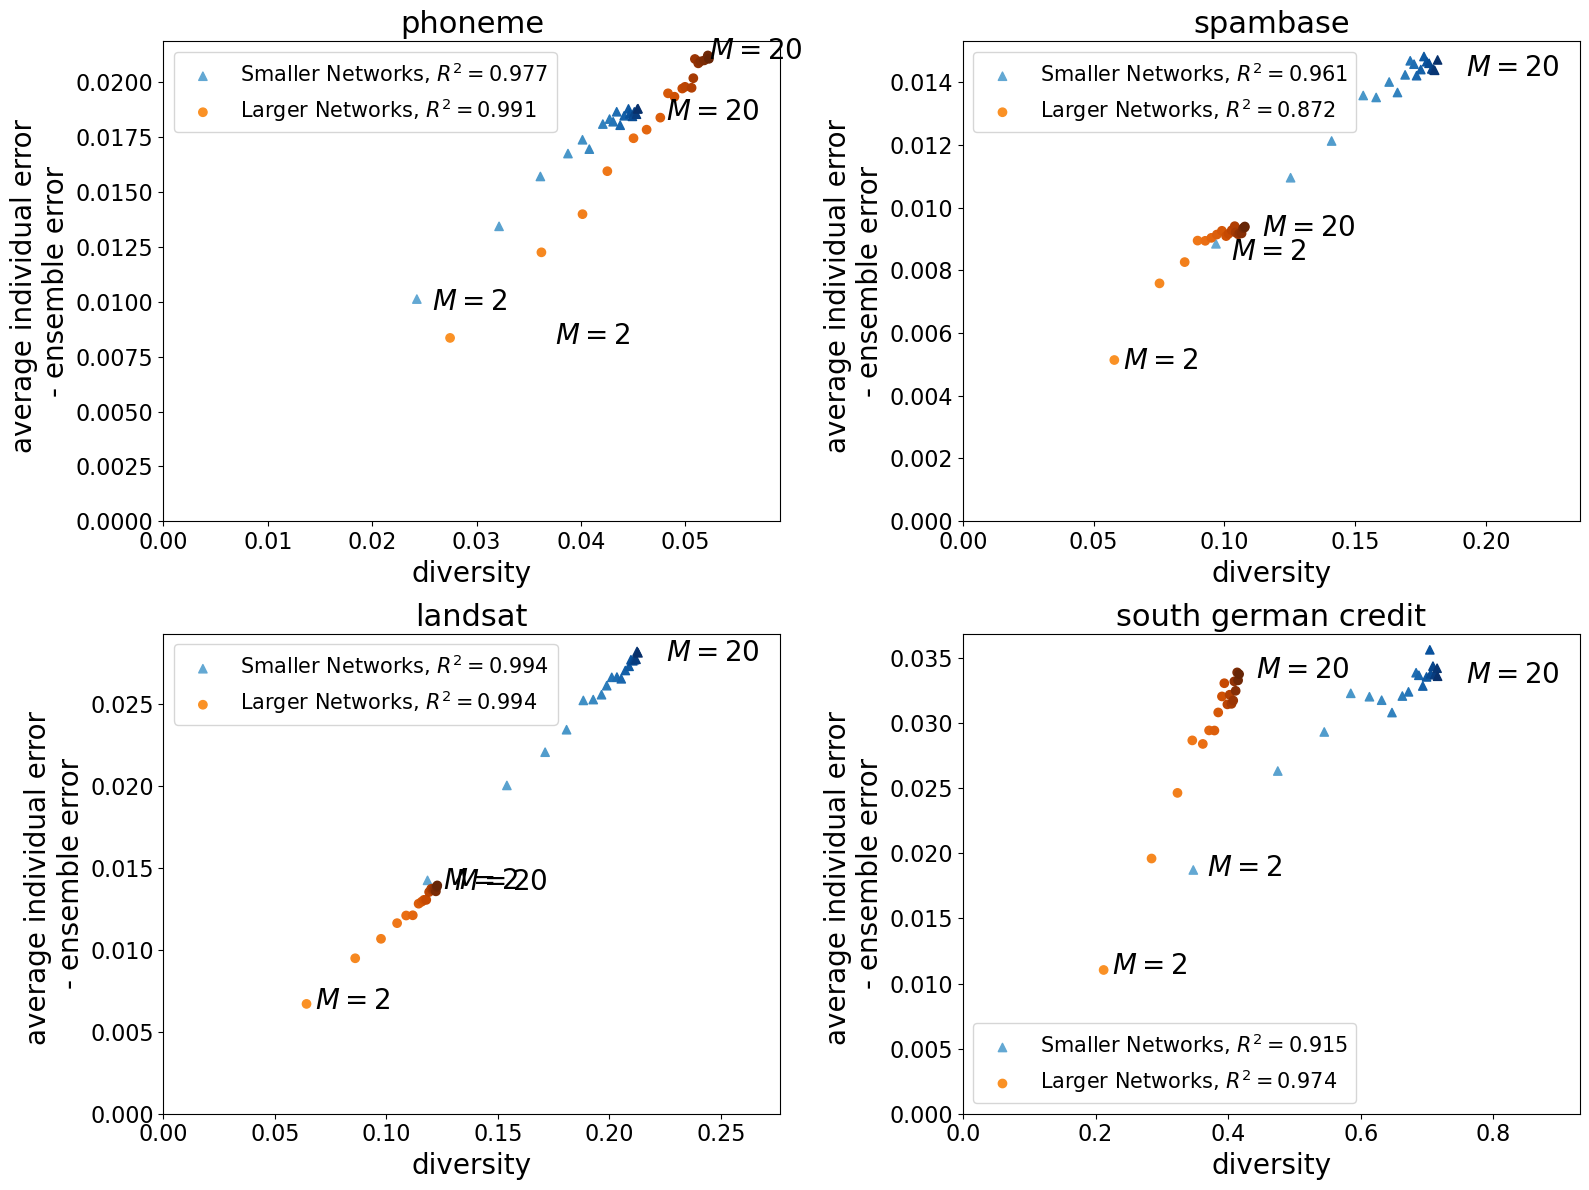

In [30]:

from scipy.stats import pearsonr
import matplotlib.ticker as plticker

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
ANNOTATION_FONTSIZE=16
FONTSIZE=20

for dataset_name, ax in zip(decomposition_objects_dict, axes.flatten()):
    
    title = dataset_name if dataset_name != "german_credit" else "south german credit"
    ax.set_title(title, size=22)
    diversities = diversities_dict[dataset_name]
    #diversities = statistics_dict[dataset_name]["diversities"]
    average_individual_errors_list = statistics_dict[dataset_name]["average_individual_errors"]
    ensemble_errors_list = statistics_dict[dataset_name]["ensemble_errors"]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


    plt.xticks(size=11)
    plt.yticks(size=11)
    

    x = np.array(diversities)
    y = np.zeros_like(diversities)



    for idx in range(len(diversities)):
        y[idx] = (average_individual_errors_list[idx] - ensemble_errors_list[idx]).mean()

    print(x.shape)
    print(y.shape)

    #loc = plticker.MultipleLocator(base=.05)
    # ax.xaxis.set_major_locator(loc)
    # ax.set_xlim(right=.28)


    small_coeff = (np.corrcoef(x[1:20], y[1:20])**2)[0,1]
    large_coeff = (np.corrcoef(x[21:40], y[21:40])**2)[0,1]
    print(f"dataset: {dataset_name}")
    ax.scatter(x[1:20], y[1:20], c=range(21,40), marker="^", label=f"Smaller Networks, $R^2=${small_coeff:.3f}", cmap="Blues", vmin=1)
    print(f"Small R^2 {small_coeff}")
    ax.scatter(x[21:], y[21:], c=range(21,40), label=f"Larger Networks, $R^2=${large_coeff:.3f}", cmap="YlOrBr", vmin=1)
    print(f"Large R^2 {large_coeff}")
    # ax.scatter(x[21:], y[21:], c=range(21,40), cmap="YlOrBr", vmin=1)

    
    for idx in [1, 19]:
        ax.annotate(f"$M={idx + 1}$", (x[idx] * 1.06, y[idx] - 0.0005 ), fontsize=FONTSIZE)
        if dataset_name != "phoneme":
            ax.annotate(f"$M={idx + 1}$", (x[idx + 20] * 1.06 , y[idx + 20] - 0.0003), fontsize=FONTSIZE )
    
    if dataset_name == "phoneme":
        ax.annotate(f"$M={2}$", (x[21] + 0.01 , y[21] - 0.0003), fontsize=FONTSIZE )
        #ax.annotate(f"$M={10}$", (x[29] - 0.013 , y[29] - 0.0003), fontsize=FONTSIZE )
        ax.annotate(f"$M={20}$", (x[39]  , y[39] ), fontsize=FONTSIZE )


    ax.set_xlabel("diversity", fontsize=FONTSIZE)
    ax.set_xlim(left=0, right=x[19] * 1.3)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis="x", labelsize= 16)
    ax.tick_params(axis="y", labelsize= 16)
    ax.set_ylabel("average individual error \n- ensemble error", fontsize=FONTSIZE)
    ax.legend(prop={"size" : 15 })
    
plt.tight_layout()
plt.savefig(f"images/scatter_diversity_all_{N_TRIALS}_mlps_v3.pdf",  bbox_inches="tight")
plt.show()
